# 计算滑动窗口内的attack score

In [13]:
import os,json,sys,logging
sys.path.append("./share")
sys.path.append("./common")
import pandas as pd
import json
from tqdm.notebook import tqdm
from IoTCommon import CIoTCommon
from IoTTotalFeature import CIoTTotalFeature
from IoTSample import CIoTSample
from SHSample import CSHSample
from SHDataProcess import CSHDataProcess
from SHFeatureSelect import CSHFeature
from Config import g_data_root,get_attack_score
from SHDataEDA import CSHDataDistribution,CSHDataTest
from SHModelClassify import CSHModelClassify
from SHEvaluation import CSHROC
import warnings
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
warnings.simplefilter("ignore")
g_sample_root = "%ssample"%g_data_root

# 测试分值计算函数

In [14]:
ioTSample = CIoTSample()

In [15]:
df_attack = pd.read_csv("./attack.csv")
df_attack['time'] = pd.to_datetime(df_attack['time'])

In [16]:
def get_test_data(attack,label=[]):
    df_tmp = df_attack[['Label','time','attack']]
    df_tmp = df_tmp[df_tmp['attack'] == attack]
    df_tmp = df_tmp[df_tmp['Label'].isin(label)]
    startTime,endTime = df_tmp['time'].min(),df_tmp['time'].max()
    date_rng = pd.date_range(start=startTime, end=endTime, freq='1S')
    df_time = pd.DataFrame({"time":date_rng})
    df_total = pd.merge(df_time, df_tmp, on='time', how='left')
    df_total['attack'] = df_total['attack'].fillna("")
    df_total['Label'] = df_total['Label'].fillna(0).astype(int)
    df_total['ts'] = df_total['time'].astype(int)// 10**9
    df_total = df_total.sort_values(by='ts').reset_index(drop = True)
    return df_total

In [29]:
def get_transformer_position_encoding(seq_length, d_model):
    position_enc = np.array([
        [pos / np.power(10000, 2 * (i // 2) / d_model) for i in range(d_model)]
        for pos in range(seq_length)
    ])
    position_enc[:, 0::2] = np.sin(position_enc[:, 0::2])  # 偶数位置
    position_enc[:, 1::2] = np.cos(position_enc[:, 1::2])  # 奇数位置
    #row_sums = np.sum(position_enc, axis=1)
    return position_enc
    
def get_attack_score(x,bar=None):
    seq_length = len(x)
    d_model = 4
    position_enc = get_transformer_position_encoding(seq_length, d_model)
    row_sums = np.sum(position_enc, axis=1)
    
    s_array = np.array(x).reshape(-1,)
    encoded_s =  s_array * row_sums 
    
    #print(s_array.shape,row_sums.shape,encoded_s.shape)
    
    encoded_sum = np.sum(encoded_s)
    if bar: bar.update(1)
    return encoded_sum

In [30]:
def test(attack):
    df_total = get_test_data(attack,[-1,1,0])
    df_tmp = df_total[['Label','ts']]
    df_tmp.loc[df_tmp['Label']==-1,"Label"]=0
    #df_tmp = CSHSample.resample_smote(df_tmp,x_columns=['ts'],y_column='Label') 
    display(df_tmp['Label'].value_counts())
    bar = tqdm(total=df_tmp.shape[0])
    ds_test = df_tmp['Label'].rolling(window=30).apply(get_attack_score, raw=True,args=(bar,)).dropna()
    ds_test = ds_test.reset_index(drop=True)
    #ds_test,v = CSHDataProcess.normal_transform(ds_test)
    #ds_test = CSHDataProcess.remove_abnormal(ds_test,ds_test.std()*3)
    #ds_test = (ds_test - ds_test.mean()) / ds_test.std()
    #ds_test,v = CSHDataProcess.normal_transform(ds_test)
    plt.hist(ds_test,bins=200,density=True, alpha=0.6, color='g')
    plt.title(attack)
    plt.show()
    return ds_test

Label
0    18183
1    11974
Name: count, dtype: int64

  0%|          | 0/30157 [00:00<?, ?it/s]

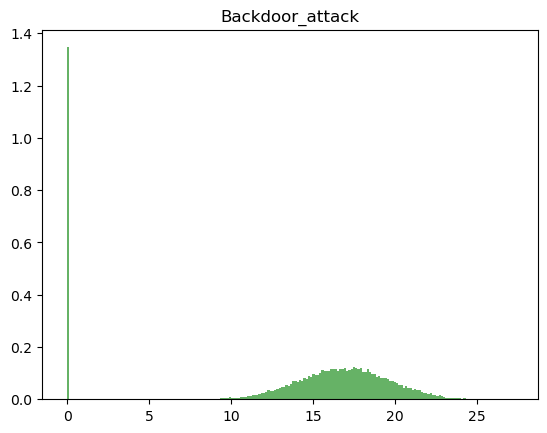

In [31]:
ds_test = test("Backdoor_attack")
#CSHDataDistribution.show_dist(ds_test,bins=100)
#CSHDataDistribution.normal_fit(ds_test)

Port Scanning attack


Label
0    11946
1    10565
Name: count, dtype: int64

  0%|          | 0/22511 [00:00<?, ?it/s]

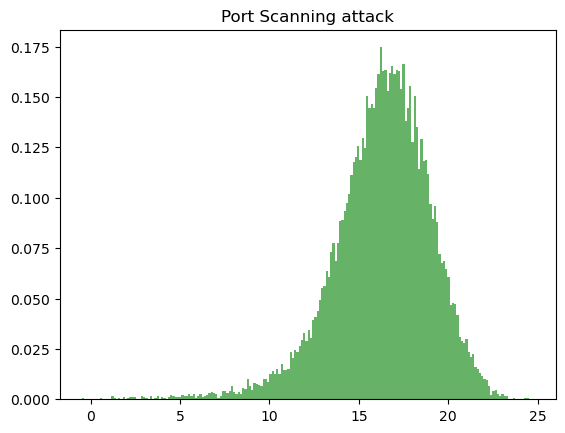

DDoS TCP SYN Flood Attacks


Label
1    1176725
0     843414
Name: count, dtype: int64

  0%|          | 0/2020139 [00:00<?, ?it/s]

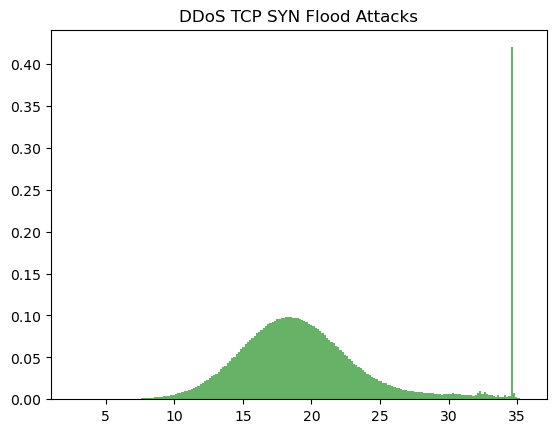

DDoS ICMP Flood Attacks


Label
1    2411219
0     503128
Name: count, dtype: int64

  0%|          | 0/2914347 [00:00<?, ?it/s]

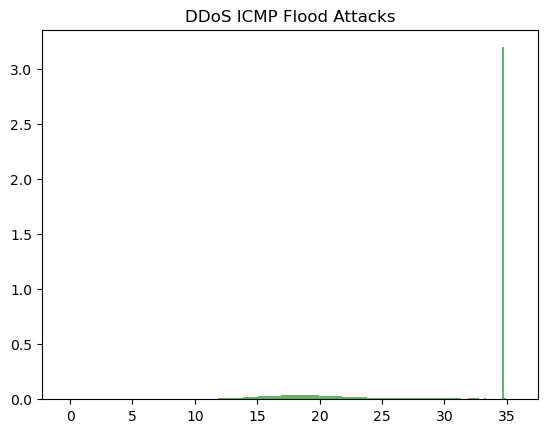

DDoS UDP Flood Attacks


Label
1    2898884
0     316835
Name: count, dtype: int64

  0%|          | 0/3215719 [00:00<?, ?it/s]

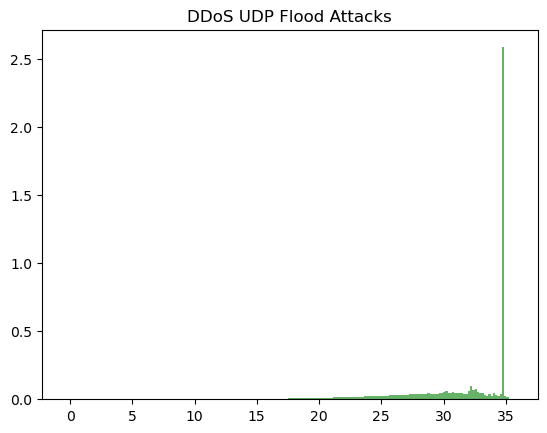

DDoS HTTP Flood Attacks


Label
1    152385
0     73493
Name: count, dtype: int64

  0%|          | 0/225878 [00:00<?, ?it/s]

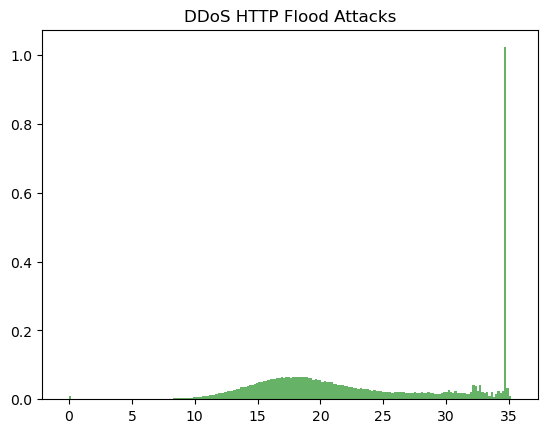

MITM (ARP spoofing + DNS) Attack


Label
0    1062
1     447
Name: count, dtype: int64

  0%|          | 0/1509 [00:00<?, ?it/s]

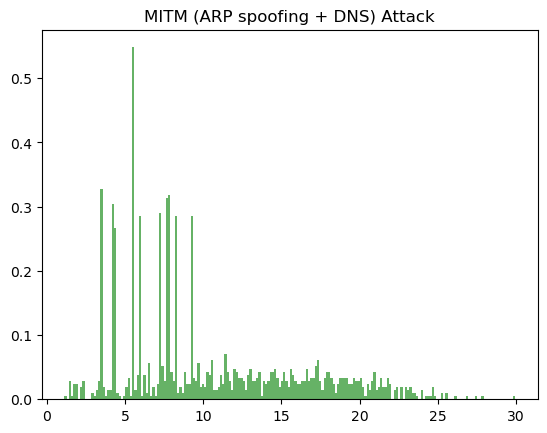

XSS attacks


Label
0    12519
1     8073
Name: count, dtype: int64

  0%|          | 0/20592 [00:00<?, ?it/s]

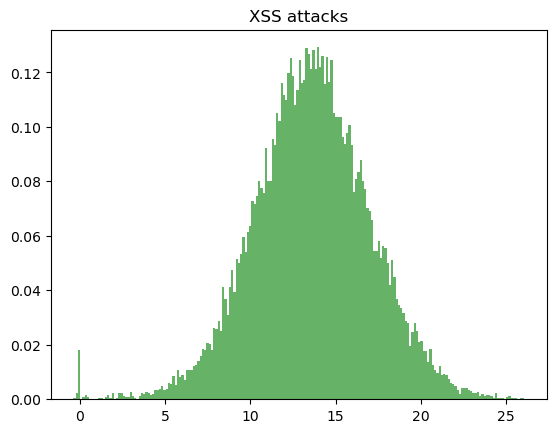

SQL injection attack


Label
1    26376
0    25011
Name: count, dtype: int64

  0%|          | 0/51387 [00:00<?, ?it/s]

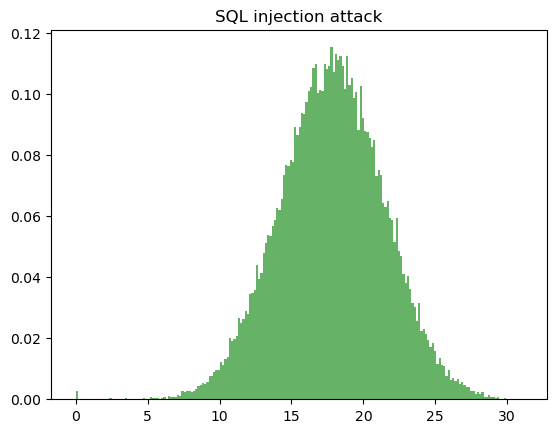

Ransomware attack


Label
0    117118
1      5021
Name: count, dtype: int64

  0%|          | 0/122139 [00:00<?, ?it/s]

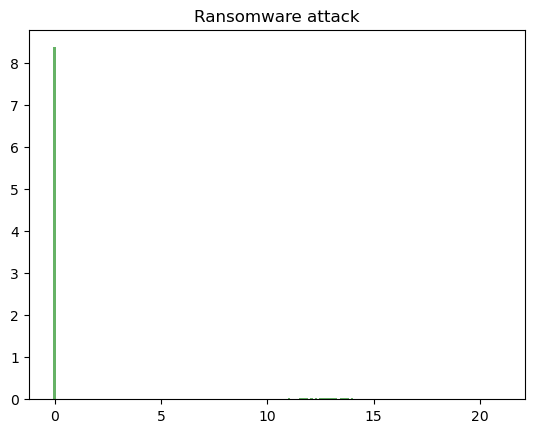

Password attacks


Label
0    536080
1    523102
Name: count, dtype: int64

  0%|          | 0/1059182 [00:00<?, ?it/s]

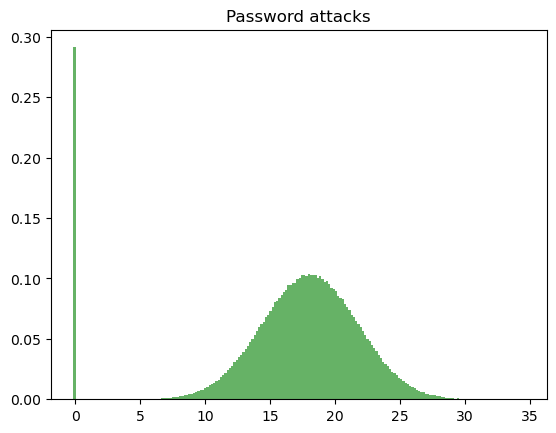

Backdoor_attack


Label
0    18183
1    11974
Name: count, dtype: int64

  0%|          | 0/30157 [00:00<?, ?it/s]

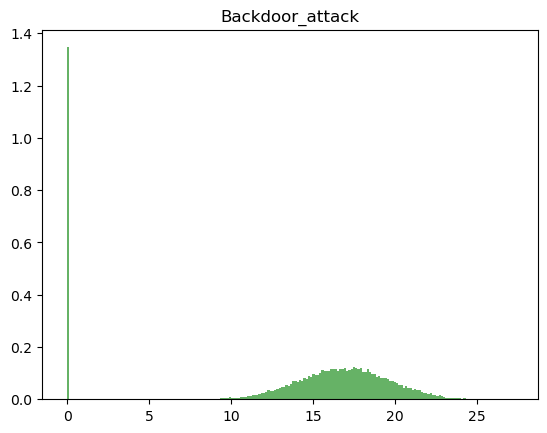

Vulnerability scanner attack


Label
1    131813
0     26502
Name: count, dtype: int64

  0%|          | 0/158315 [00:00<?, ?it/s]

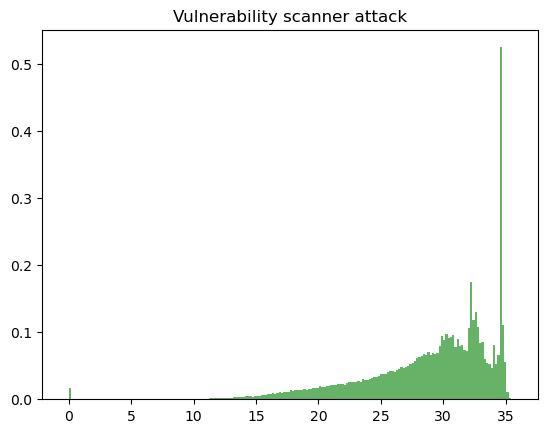

Uploading attack


Label
1    20470
0    17491
Name: count, dtype: int64

  0%|          | 0/37961 [00:00<?, ?it/s]

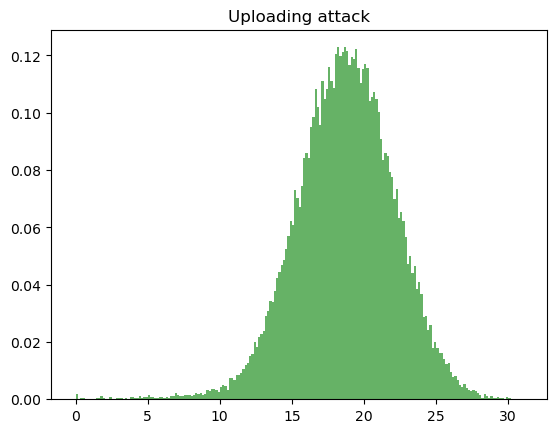

OS Fingerprinting attack


Label
0    869
1    673
Name: count, dtype: int64

  0%|          | 0/1542 [00:00<?, ?it/s]

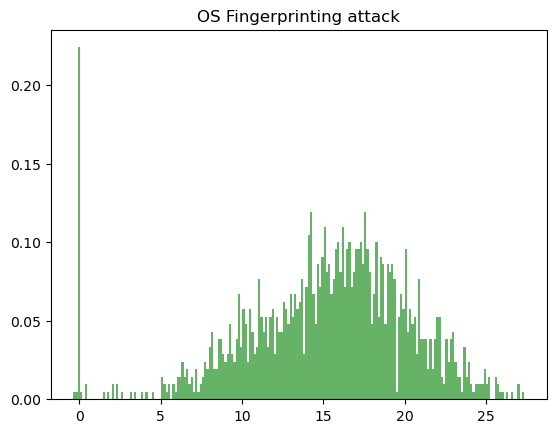

In [32]:
df_score = pd.DataFrame()
for attack in df_attack['attack'].unique().tolist():
    print(attack)
    #df_tmp = df_attack[df_attack['attack'] == attack]
    #display(df_tmp['Label'].value_counts())
    ds = test(attack)
    df_tmp = pd.DataFrame({"score":ds})
    df_tmp['attack'] = attack
    df_score = pd.concat([df_score,df_tmp],ignore_index=True)
df_score = df_score.reset_index(drop=True)
df_score.to_csv("./score.csv")

# 训练模型